<a href="https://colab.research.google.com/github/columose/WOAH-FMD-dataset/blob/main/4_Visualise_data_on_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Save figures function
def save_fig2colab(file):
  path = r'/content/drive/MyDrive/Colab Notebooks/WOAH/Script outputs/'
  plt.savefig(path + file ,bbox_inches="tight")

In [3]:
df_clean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WOAH/clean_data.csv')
df_clean.head()

,Unnamed: 0,Year,Semester,World region,Country,Administrative Division,Animal Category,Species,New outbreaks,Susceptible,Measuring units,Cases,Killed and disposed of,Slaughtered,Deaths,Vaccinated
0,0,2005,Jul-Dec 2005,Africa,Benin,Abomey,Domestic,Cattle,1,884,Animal,30,0,0,0,0
1,1,2005,Jul-Dec 2005,Africa,Benin,Banikoara,Domestic,Cattle,2,1202,Animal,96,0,4,78,0
2,2,2005,Jul-Dec 2005,Africa,Benin,Come,Domestic,Cattle,2,224,Animal,100,0,0,2,0
3,3,2005,Jul-Dec 2005,Africa,Benin,Djougou,Domestic,Cattle,1,54,Animal,7,0,0,0,0
4,4,2005,Jul-Dec 2005,Africa,Benin,Gogounou,Domestic,Cattle,1,252,Animal,22,0,0,0,0


In [4]:
# Group data by country for plotting

grouping_vars_new = ['Country']
test_vars = ['New outbreaks','Susceptible','Cases','Killed and disposed of','Slaughtered',
             'Deaths','Vaccinated']

# Group data
df_grouped_new = df_clean.groupby(grouping_vars_new)[test_vars].sum()

In [8]:
# Convert country-grouped dataframe to geopandas dataframe for plotting

import geopandas as gpd

# Download the 'naturalearth_lowres' dataset for geometric coordinates
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# merge coordinates with df countries
merged_gdf = world.merge(df_grouped_new, how='left', left_on='name', right_on='Country')

# Filter out NaN rows
merged_gdf = merged_gdf.dropna(subset=['New outbreaks'])

merged_gdf.head()

<ipython-input-8-403a9cab938f>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,New outbreaks,Susceptible,Cases,Killed and disposed of,Slaughtered,Deaths,Vaccinated
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",480.0,1307913.0,42006.0,0.0,0.0,592.0,22262.0
5,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",83.0,67975.0,11427.0,18679.0,0.0,12.0,480132.0
8,270625568.0,Asia,Indonesia,IDN,1119190,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",155881.0,0.0,618798.0,0.0,0.0,0.0,0.0
9,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",10.0,0.0,71.0,5051.0,0.0,0.0,95952.0
12,10192317.3,Africa,Somalia,SOM,4719,"POLYGON ((41.58513 -1.68325, 40.99300 -0.85829...",252.0,33427.0,2486.0,0.0,0.0,158.0,0.0


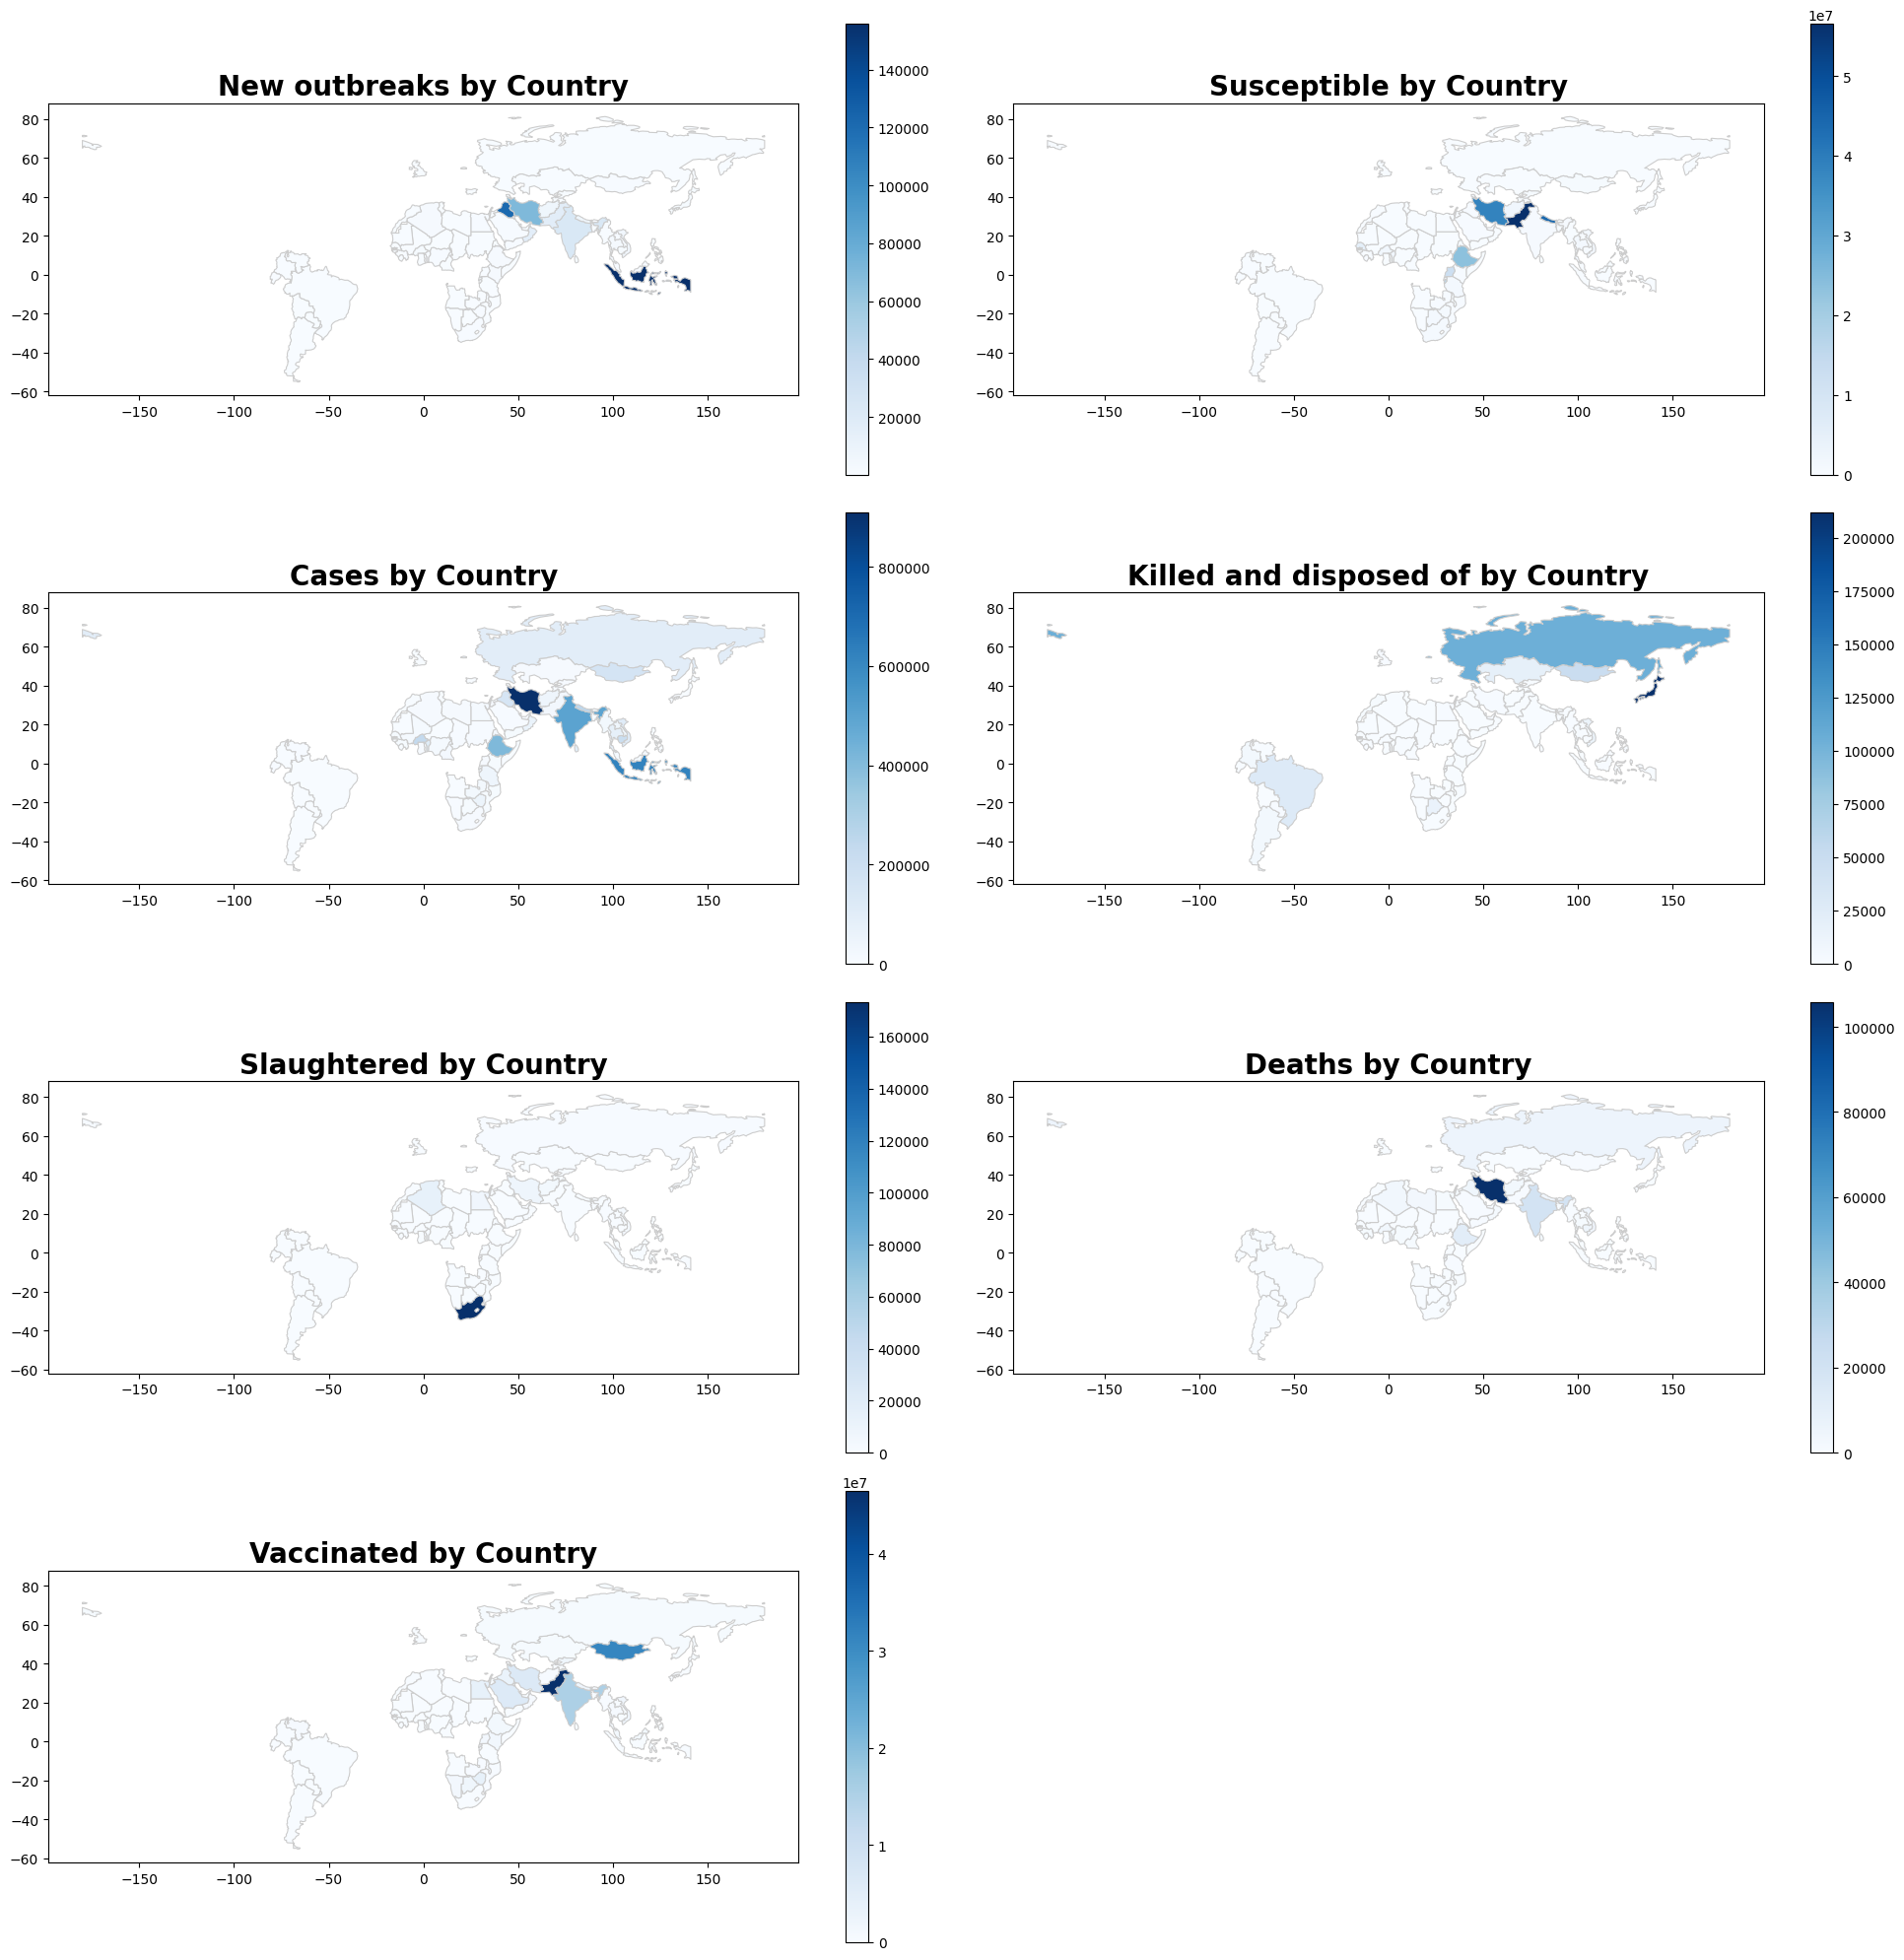

In [9]:
# Create nice subplots with country data

fig, axs = plt.subplots(4,2,figsize=(20, 20))

for ivar, var in enumerate(test_vars):
    row_idx, col_idx = divmod(ivar, 2)  # Determine subplot row and column
    merged_gdf.plot(column=var, cmap='Blues', linewidth=0.8, ax=axs[row_idx, col_idx], edgecolor='0.8', legend=True)

    axs[row_idx, col_idx].set_title(f'{var} by Country', fontdict={'fontsize': '20', 'fontweight': 'bold'})


fig.delaxes(axs[3,1]) # Delete axis that contains no data
plt.tight_layout()

#save_fig2colab('Choropleth original')
plt.show()

**Perform k means clustering and plot the results**

In [10]:
!pip install kneed

In [11]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

<Axes: >

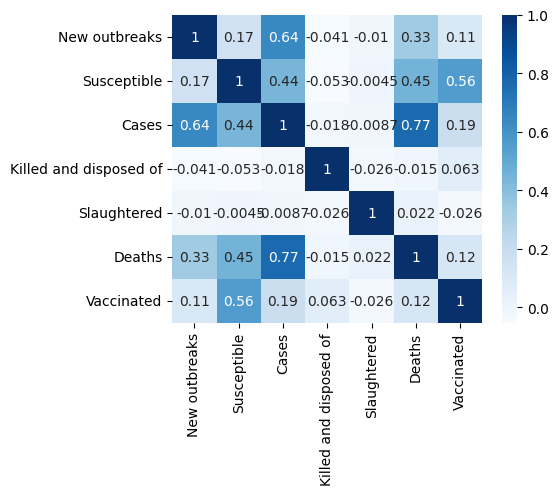

In [34]:
# First step, see which variables are correlated for dimensionality reduction

fig = plt.figure(figsize = (5,4))
cluster_gdf = merged_gdf[test_vars] # Create temporary dataset with quantitative data
corr = cluster_gdf.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

**Grouping observations**
The following sets show high correlation: new outbreaks, cases; susceptible, vaccinated; cases, deaths, new outbreaks; deaths, cases.

Therefore, the following groups will be made:
1. Susceptible, vaccinated.
2. Cases, deaths, new outbreaks.
3. Slaughtered
4. Killed and disposed of

In [13]:
# Define correlated variables
corr_vars = [['Susceptible','Vaccinated'],['Cases','New outbreaks','Deaths'],['Slaughtered'],['Killed and disposed of']]

# Create dataframe for test variables so the data can be scaled
scaled_dfs = []
for igrp in range(len(corr_vars)):
  scaled_df = StandardScaler().fit_transform(cluster_gdf[corr_vars[igrp]])
  scaled_dfs.append(scaled_df)

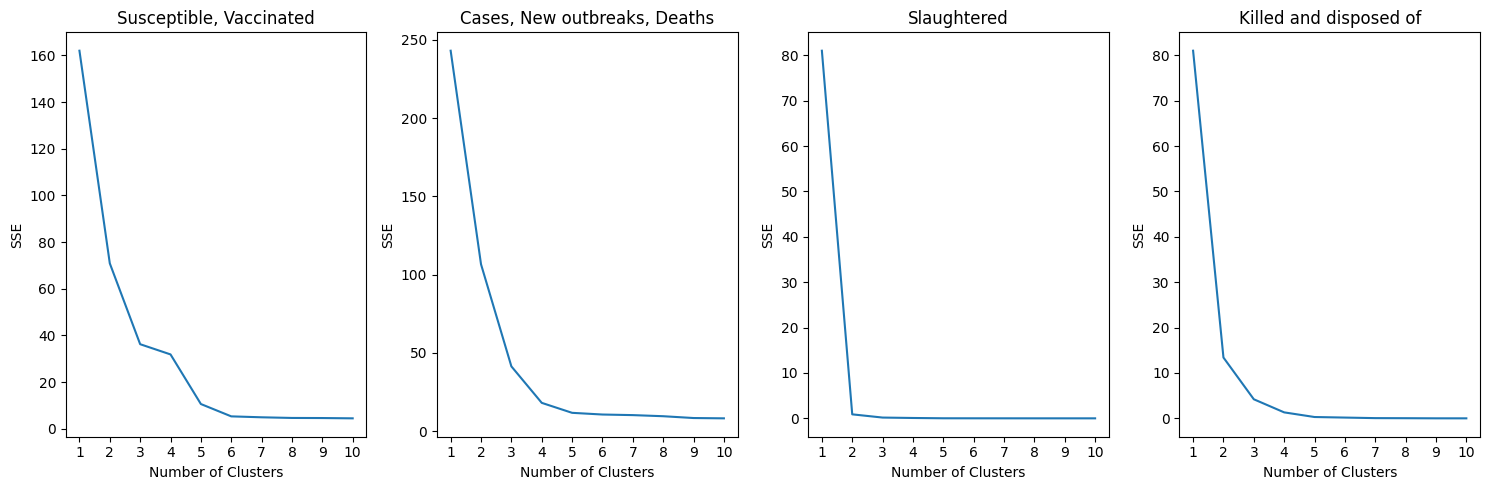

In [14]:
# Plot elbow graph to determine the optimal number of clusters per grouping of variables

fig, axs = plt.subplots(1, len(scaled_dfs), figsize = (15,5))

for igrp in range(len(scaled_dfs)):
    #initialize kmeans parameters
    kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "random_state": 1,
    }

    #create list to hold SSE sum of squared error) values for each k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_dfs[igrp])
        sse.append(kmeans.inertia_)

    #visualize results
    axs[igrp].plot(range(1, 11), sse)
    axs[igrp].set_xticks(range(1, 11))
    axs[igrp].set_xlabel("Number of Clusters")
    axs[igrp].set_ylabel("SSE")
    axs[igrp].set_title(', '.join(corr_vars[igrp]))

plt.tight_layout()

#save_fig2colab('Number of clusters')
plt.show()

**Observations**

Group 1 - elbow bend at 5 clusters.

Group 2 - elbow bend at 4 clusters.

Group 3 - elbow bend at 2 clusters.

Group 4 - elbow bend at 3 clusters.

In [15]:
# Perform kmeans clustering

n_clusters = [5, 4, 2, 3]
kmeans = []
for igrp in range(len(scaled_dfs)):
  #instantiate the k-means class, using optimal number of clusters
  kmeans.append(KMeans(init="random", n_clusters=n_clusters[igrp], n_init=10, random_state=1))

  #fit k-means algorithm to data
  kmeans[igrp].fit(scaled_df)

  #view cluster assignments for each observation
  kmeans[igrp].labels_

In [16]:
# Visualise the new dataset with the cluster labels

for igrp in range(len(scaled_dfs)):
  merged_gdf[f'cluster{igrp}'] = kmeans[igrp].labels_

merged_gdf.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,New outbreaks,Susceptible,Cases,Killed and disposed of,Slaughtered,Deaths,Vaccinated,cluster0,cluster1,cluster2,cluster3
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",480.0,1307913.0,42006.0,0.0,0.0,592.0,22262.0,0,0,0,0
5,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",83.0,67975.0,11427.0,18679.0,0.0,12.0,480132.0,2,2,0,0
8,270625568.0,Asia,Indonesia,IDN,1119190,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",155881.0,0.0,618798.0,0.0,0.0,0.0,0.0,0,0,0,0
9,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",10.0,0.0,71.0,5051.0,0.0,0.0,95952.0,0,0,0,0
12,10192317.3,Africa,Somalia,SOM,4719,"POLYGON ((41.58513 -1.68325, 40.99300 -0.85829...",252.0,33427.0,2486.0,0.0,0.0,158.0,0.0,0,0,0,0


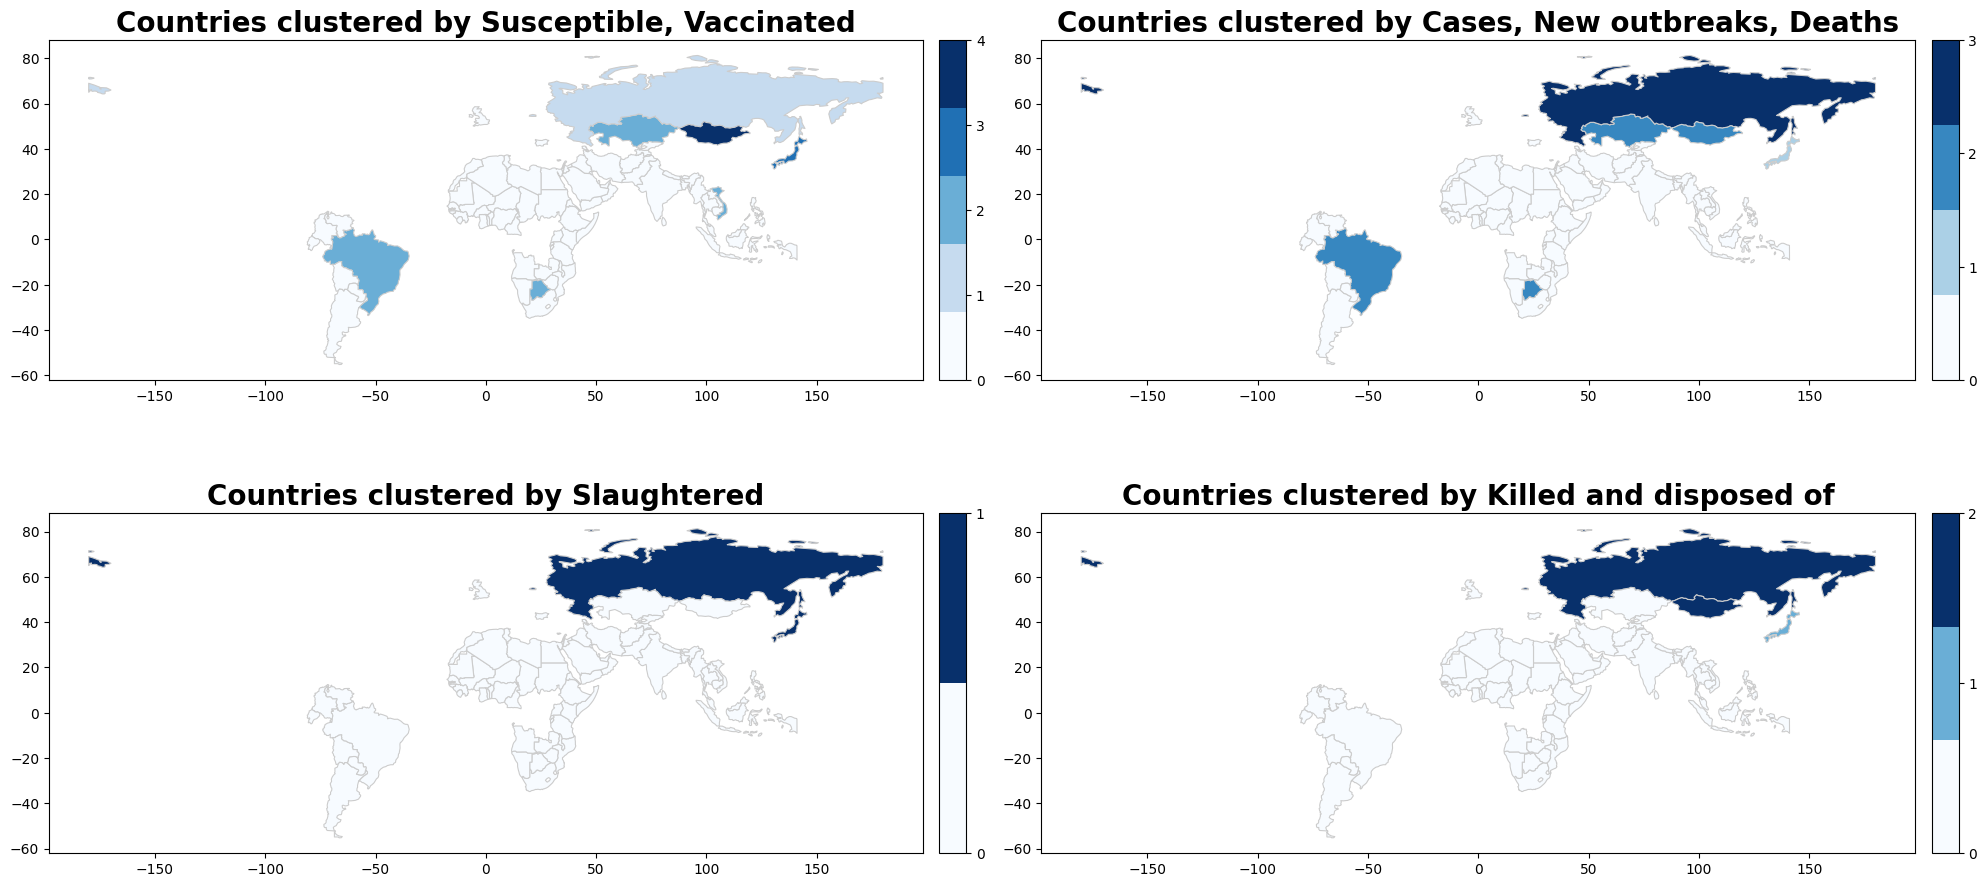

In [31]:
# Choropleth of clustered countries
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

fig, axs = plt.subplots(2,2, figsize = (20,10))

for igrp, grp in enumerate(corr_vars):
    row_idx, col_idx = divmod(igrp, 2)  # Determine subplot row and column
    merged_gdf.plot(column= f'cluster{igrp}', cmap = 'Blues', linewidth=0.8,
                    ax=axs[row_idx, col_idx], edgecolor='0.8', legend=False)

    grp = ', '.join(grp)
    axs[row_idx, col_idx].set_title(f'Countries clustered by {grp}',
                                    fontdict={'fontsize': '20', 'fontweight': 'bold'})

    # axis for the color bar
    div = make_axes_locatable(axs[row_idx,col_idx])
    cax = div.append_axes("right", size ="3 %", pad = 0.05)

    # Create a custom colormap based on an array of colors
    colors = plt.cm.Blues(np.linspace(0, 1, n_clusters[igrp]))
    custom_cmap = ListedColormap(colors)

    # color bar
    cbar_ticks = list(range(n_clusters[igrp]))
    vmax = n_clusters[igrp] - 1
    mappable = plt.cm.ScalarMappable(cmap = custom_cmap,
                                 norm = plt.Normalize(vmin = 0, vmax = vmax))
    cbar = fig.colorbar(mappable, cax, cbar_ticks)
    cbar.set_ticks(cbar_ticks)


plt.tight_layout()

save_fig2colab('Choropleth clusters')
plt.show()
